<a href="https://colab.research.google.com/github/dine1717/EVA6/blob/Session5/Step_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:

import sys
sys.path.append('/content/drive/MyDrive/models')

In [6]:

# Auto reload the modules
%load_ext autoreload
%autoreload 2


In [7]:
from model import Model_6

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [8]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       #transforms.RandomErasing(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [9]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 362821461.25it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 40567881.39it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 141931401.41it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22733327.89it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [10]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The model

## Target
1. Less than 9000 parameters
2. Less than 15 epochs
3. Test with Cyclic LR
4. Add small dropout of 5%

## Results
1. Number of Parameters = 6202 + 140 non trainable BN params
2. Best Train Accuracy = 98.97
3. Best Test Accuracy = 99.45

## Analysis
1. We pushed the model to achieve target with approx 6000 Parameters
2. Drop in accuracy was predicted because of making the training more difficult. But still we met the target.

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [16]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model_6().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
       BatchNorm2d-2           [-1, 10, 28, 28]              20
              ReLU-3           [-1, 10, 28, 28]               0
           Dropout-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 10, 28, 28]             900
       BatchNorm2d-6           [-1, 10, 28, 28]              20
              ReLU-7           [-1, 10, 28, 28]               0
           Dropout-8           [-1, 10, 28, 28]               0
         MaxPool2d-9           [-1, 10, 14, 14]               0
           Conv2d-10           [-1, 10, 12, 12]             900
      BatchNorm2d-11           [-1, 10, 12, 12]              20
             ReLU-12           [-1, 10, 12, 12]               0
          Dropout-13           [-1, 10, 12, 12]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [14]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
train_epoch_end = []

def train(model, device, train_loader, optimizer, epoch,scheduler):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    scheduler.step()
  train_epoch_end.append(train_acc[-1])

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [17]:
#from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import OneCycleLR
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=15)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, scheduler)
    print('Epoch:', epoch,'LR:', scheduler.get_lr())
    #scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.13017213344573975 Batch_id=468 Accuracy=80.41: 100%|██████████| 469/469 [00:21<00:00, 21.96it/s]

Epoch: 0 LR: [0.015240079703465942]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:1761: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "



Test set: Average loss: 0.1025, Accuracy: 9694/10000 (96.94%)

EPOCH: 1


Loss=0.06909143179655075 Batch_id=468 Accuracy=96.79: 100%|██████████| 469/469 [00:21<00:00, 22.20it/s]

Epoch: 1 LR: [0.04369617749135263]



Test set: Average loss: 0.0630, Accuracy: 9806/10000 (98.06%)

EPOCH: 2


Loss=0.10743734985589981 Batch_id=468 Accuracy=97.34: 100%|██████████| 469/469 [00:20<00:00, 22.85it/s]

Epoch: 2 LR: [0.07604125973093226]



Test set: Average loss: 0.0468, Accuracy: 9859/10000 (98.59%)

EPOCH: 3


Loss=0.09574183076620102 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:25<00:00, 18.43it/s]

Epoch: 3 LR: [0.09712693882270339]



Test set: Average loss: 0.0367, Accuracy: 9898/10000 (98.98%)

EPOCH: 4


Loss=0.029632145538926125 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:23<00:00, 20.38it/s]

Epoch: 4 LR: [0.09943677941594807]



Test set: Average loss: 0.0303, Accuracy: 9907/10000 (99.07%)

EPOCH: 5


Loss=0.06858939677476883 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:22<00:00, 20.73it/s]

Epoch: 5 LR: [0.09503461424944769]



Test set: Average loss: 0.0326, Accuracy: 9908/10000 (99.08%)

EPOCH: 6


Loss=0.043606262654066086 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:21<00:00, 21.80it/s]

Epoch: 6 LR: [0.0866309437466121]



Test set: Average loss: 0.0242, Accuracy: 9927/10000 (99.27%)

EPOCH: 7


Loss=0.014845837838947773 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:22<00:00, 20.57it/s]

Epoch: 7 LR: [0.0749724709105188]



Test set: Average loss: 0.0257, Accuracy: 9921/10000 (99.21%)

EPOCH: 8


Loss=0.01515855360776186 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:23<00:00, 19.69it/s]


Epoch: 8 LR: [0.061095102215020056]

Test set: Average loss: 0.0241, Accuracy: 9928/10000 (99.28%)

EPOCH: 9


Loss=0.0017841695807874203 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:23<00:00, 19.73it/s]

Epoch: 9 LR: [0.046231902768540376]



Test set: Average loss: 0.0216, Accuracy: 9930/10000 (99.30%)

EPOCH: 10


Loss=0.01948796771466732 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:25<00:00, 18.50it/s]

Epoch: 10 LR: [0.031703533067975895]



Test set: Average loss: 0.0235, Accuracy: 9926/10000 (99.26%)

EPOCH: 11


Loss=0.06226624548435211 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:23<00:00, 20.19it/s]

Epoch: 11 LR: [0.018800902517922092]



Test set: Average loss: 0.0221, Accuracy: 9933/10000 (99.33%)

EPOCH: 12


Loss=0.0025025000795722008 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:21<00:00, 22.08it/s]

Epoch: 12 LR: [0.008670466465012771]



Test set: Average loss: 0.0186, Accuracy: 9941/10000 (99.41%)

EPOCH: 13


Loss=0.04146011918783188 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:21<00:00, 21.63it/s]

Epoch: 13 LR: [0.0022123586092353013]



Test set: Average loss: 0.0183, Accuracy: 9943/10000 (99.43%)

EPOCH: 14


Loss=0.03187761455774307 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:21<00:00, 22.00it/s]

Epoch: 14 LR: [4.101745150496986e-07]



Test set: Average loss: 0.0181, Accuracy: 9950/10000 (99.50%)



Text(0.5, 1.0, 'Test Accuracy')

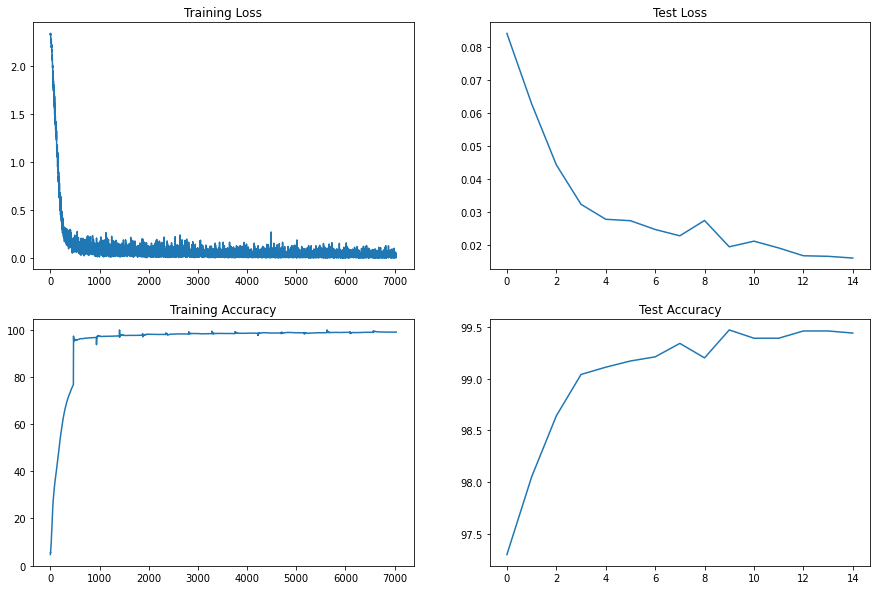

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

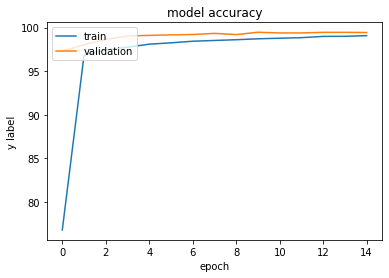

99.07833333333333
99.47


In [ ]:
plt.plot(train_epoch_end)
plt.plot(test_acc)
plt.title('model accuracy')
plt.ylabel('y label')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
print(max(train_epoch_end[:15]))
print(max(test_acc[:15]))